lon [-87.880257, -85.803612, -87.6381, -88.013802, -85.970062]
lat [30.497478, 33.284927, 34.762619, 34.7589, 34.289001]
value [-6, -6, -6, -6, -6]


/home/esil/anaconda3/envs/devin_env/lib/python3.9/site-packages/esil/rsm_helper/model_property.py:75: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  self.lats, self.lons = transform(projection, 'EPSG:4326',grid_x, grid_y)


Points data for gmt_offset: {'lon': [-87.880257, -85.803612, -87.6381, -88.013802, -85.970062, -86.136589, -86.232346, -86.255196, -85.992554, -86.053864, -85.423096, -85.720802, -86.815002, -86.915001, -87.003609, -87.305557, -86.549164, -86.816666, -86.669167, -86.942497, -86.773888, -87.339729, -86.880814, -86.588158, -86.756172, -88.087761, -88.141022, -86.263397, -86.967537, -85.08345, -84.999657, -86.825752, -88.201866, -88.277992, -86.122643, -87.459732, -87.481506, -87.11853, -109.389061, -111.652779, -111.651093, -112.183601, -111.107399, -113.558601, -112.142563, -111.865356, -112.066193, -111.733269, -112.191933, -111.855751, -112.046593, -111.917213, -111.967087, -112.192932, -111.892921, -112.075256, -111.884262, -111.934708, -112.385498, -112.017258, -112.34185, -112.620682, -111.676926, -112.163055, -112.160599, -111.855446, -111.755333, -111.805771, -111.838516, -111.798714, -111.410004, -111.609718, -111.725342, -111.671829, -112.287659, -112.8311, -112.095764, -109.89

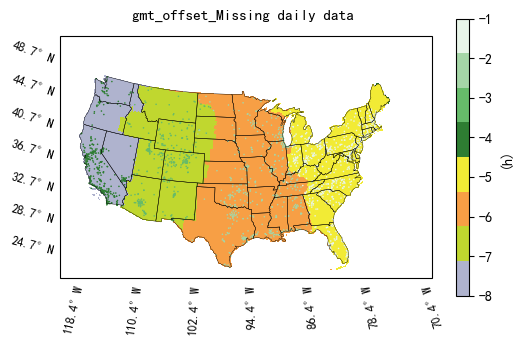

The data fusion plot for gmt_offset is saved to /DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap/gmt_offset_Missing daily data.png
Done!


In [ ]:
import os
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# for show maps
from esil.rsm_helper.model_property import model_attribute
from esil.map_helper import get_multiple_data, show_maps
import cmaps

# 自定义颜色系列
custom_colors = {
    "-8": "#afb3ce",
    "-7": "#c0d72f",
    "-6": "#f79f45",
    "-5": "#f2eb35",
    "-4(Point-8)":"#2e7d32",
    "-3(Point-7)":"#66bb6a",
    "-2(Point-6)":"#a5d6a7",
    "-1(Point-5)":"#e8f5e9",
}

# 创建自定义颜色映射
cmap_conc = ListedColormap([custom_colors["-8"], custom_colors["-7"], custom_colors["-6"], custom_colors["-5"],custom_colors["-4(Point-8)"],custom_colors["-3(Point-7)"],
                            custom_colors["-2(Point-6)"],custom_colors["-1(Point-5)"]])
cmap_delta = cmaps.ViBlGrWhYeOrRe


def plot_us_map(
    fusion_output_file,
    model_file,
    grid_column,  # 网格数据指定列
    monitor_column,  # 监测数据指定列
    save_path=None,
    boundary_json_file="/DeepLearning/mnt/Devin/boundary/USA_State.json",
    points_data=None,  # 点数据
    set_zero=True  # 添加参数来控制是否将浓度设置为零
):
    """
    description: plot the US map with different data fusion results
    @param {string} fusion_output_file: the data fusion output file
    @param {string} model_file: the model file used for data fusion
    @param {string} grid_column: 网格数据指定列
    @param {string} monitor_column: 监测数据指定列
    @param {string} save_path: the path to save the plot
    @param {string} boundary_json_file: the boundary file for the US map
    @param {dictionary} points_data: 点数据，包含经纬度和浓度值，default=None
    @param {bool} set_zero: 是否将浓度值设置为0，默认False
    @return None
    """
    # 注意
    mp = model_attribute(model_file)
    proj, longitudes, latitudes = mp.projection, mp.lons, mp.lats
    df_data = pd.read_csv(fusion_output_file)
    if grid_column not in df_data.columns:
        print(f"The data fusion file does not contain the {grid_column} column!")
        return
    layout = None

    # 移除对Period的依赖，不再有周期循环
    dict_data = {}

    # 检查是否存在指定列的数据
    if grid_column not in df_data.columns or df_data[grid_column].empty:
        print(f"No data found in {grid_column}. Skipping.")
        return

    # 获取原始浓度数据
    grid_concentration_model = df_data[grid_column].values

    # 确保数据大小与网格形状一致
    if grid_concentration_model.size != longitudes.size:
        print(f"Data size mismatch. Expected size {longitudes.size}, but found {grid_concentration_model.size}.")
        return

    grid_concentration_model = grid_concentration_model.reshape(longitudes.shape)

    vmax_conc = np.nanpercentile(grid_concentration_model, 99.5)
    vmin_conc = np.nanpercentile(grid_concentration_model, 0.5)
    value_range = [-8, -1]

    # 提取特定列的点数据
    points_data_period = points_data.get(monitor_column, None)
    if points_data_period:
        # 设定点大小为15,以及指定颜色
        points_data_period['symbol_size'] = [1.3] * len(points_data_period['lon'])
        points_data_period['edgecolor'] = 'None'
        points_data_period['cmaq'] = 'jet'
        points_data_period['value'] = [v + 4 for v in points_data_period['value']]
        print(f"Points data for {monitor_column}: {points_data_period}")
        # 添加点数据到dict_data
        get_multiple_data(
            dict_data,
            dataset_name=f"{monitor_column}_Missing daily data",
            variable_name="",
            grid_x=longitudes,
            grid_y=latitudes,
            grid_concentration=grid_concentration_model,
            points_data=points_data_period  # 传入点数据
        )
    else:
        print(f"No points data found for {monitor_column}")

    fig = show_maps(
        dict_data,
        unit="h",
        cmap=cmap_conc,
        show_lonlat=True,
        projection=proj,
        is_wrf_out_data=True,
        boundary_file=boundary_json_file,
        show_original_grid=True,
        show_grid_line=None,
        panel_layout=layout,
        show_minmax=False,
        delta_map_settings={
            "cmap": cmap_conc,
            "value_range": (0, 10),
            "colorbar_ticks_num": None,
            "colorbar_ticks_value_format": ".2f",
            "value_format": ".2f",
        },
        title_fontsize=11,
        xy_title_fontsize=9,
        show_dependenct_colorbar=True,
        value_range=value_range,
    )

    if save_path is not None:
        save_file = os.path.join(save_path, f"{monitor_column}_Missing daily data.png")
        fig.savefig(save_file, dpi=300)
        print(f"The data fusion plot for {monitor_column} is saved to {save_file}")
    dict_data = {}


if __name__ == "__main__":
    save_path = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/TestMap"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    model_file = r"/backupdata/data_EPA/EQUATES/EQUATES_data/HR2DAY_LST_ACONC_v532_cb6r3_ae7_aq_WR413_MYR_STAGE_2011_12US1_2011.nc"
    data_fusion_file = r"/DeepLearning/mnt/shixiansheng/data_fusion/output/Region/2011_ROWCOLRegion_Tz_CONUS_ST.csv"

    points_data_df = pd.read_csv('/DeepLearning/mnt/shixiansheng/data_fusion/output/Region/MonitorsTimeRegion_Filter_ST_QA_Compare.csv')
    points_data = {}
    monitor_column = 'gmt_offset'  # 监测数据指定列
    grid_column = 'gmt_offset'  # 网格数据指定列

    period_data = points_data_df[points_data_df[monitor_column].notna()]

    # 过滤掉极端的经纬度，远离美国陆地外的监测站
    period_data = period_data[(period_data['Lon'] >= -134.4) & (period_data['Lon'] <= -70)]
    points_data[monitor_column] = {'lon': period_data['Lon'].tolist(),
                                   'lat': period_data['Lat'].tolist(),
                                   'value': period_data[monitor_column].tolist()}

    # 打印前五行数据
    for key in points_data[monitor_column]:
        print(key, points_data[monitor_column][key][:5])

    # True set_zero可以使得背景模型浓度vna置为0
    for file in [data_fusion_file]:
        plot_us_map(file, model_file, grid_column, monitor_column, save_path, points_data=points_data, set_zero=True)
    print("Done!")